In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

In [3]:
path = Path('/root/.fastai/meggitt')

In [4]:
path

PosixPath('/root/.fastai/meggitt')

In [5]:
df = pd.read_csv(path/'meggitt_prices_year_only.csv', sep=',')

In [6]:
df.columns = ['customer_region', 'customer_segment', 'customer_division', 'customer_planning_entity', 'customer_account_manager', 'product_type_of_sales', 
              'product_segment', 'product_planning_entity', 'product_description', 'product_production_site', 'product_platform',
             'year', 'planning_price']

In [7]:
df.head(7)

,customer_region,customer_segment,customer_division,customer_planning_entity,customer_account_manager,product_type_of_sales,product_segment,product_planning_entity,product_description,product_production_site,product_platform,year,planning_price
0,Americas,Aircraft Operators,Civil,"ABC AEROLINEAS, S.A. DE C.V.",Jordi Debertomeu,FA_Eng/Svc Chge,TBD,TBD,AOG fee,Not Applicable,Unknown,2020,0.000000
1,Americas,Aircraft Operators,Civil,"ABC AEROLINEAS, S.A. DE C.V.",Jordi Debertomeu,MRO,Electronics Fribourg,241-246-022-004,Engine Vibration Monitoring Unit,MSS CH Fribourg,A32x (Airframe),2019,3058.268591
2,Americas,Aircraft Operators,Civil,"ABC AEROLINEAS, S.A. DE C.V.",Jordi Debertomeu,MRO,Electronics Fribourg,241-246-022-004,Engine Vibration Monitoring Unit,MSS CH Fribourg,A32x (Airframe),2020,3058.268591
3,Americas,Aircraft Operators,Civil,"ABC AEROLINEAS, S.A. DE C.V.",Jordi Debertomeu,MRO,Fire Bottles Simi,Fire Bottles Simi,"150 CU IN, 536 . 2 OUT, SINGLE OUTLET WITH TC...",MCS US Simi,"SJ-100 / SaM146,Unknown",2019,1502.055443
4,Americas,Aircraft Operators,Civil,"ABC AEROLINEAS, S.A. DE C.V.",Jordi Debertomeu,MRO,Fire Bottles Simi,Fire Bottles Simi,"150 CU IN, 536 . 2 OUT, SINGLE OUTLET WITH TC...",MCS US Simi,"SJ-100 / SaM146,Unknown",2020,1502.055443
5,Americas,Aircraft Operators,Civil,"ABC AEROLINEAS, S.A. DE C.V.",Jordi Debertomeu,MRO,Fire Detector Electronics Simi,Fire Detector Electronics Simi,SMOKE DETECTOR,MCS US Simi,Unknown,2019,633.668988
6,Americas,Aircraft Operators,Civil,"ABC AEROLINEAS, S.A. DE C.V.",Jordi Debertomeu,MRO,Fire Detector Electronics Simi,Fire Detector Electronics Simi,SMOKE DETECTOR,MCS US Simi,Unknown,2020,633.668988


In [8]:
df.shape

(31521, 13)

In [9]:
df['customer_region'].unique()

array(['Americas', 'APAC', 'EMEA', 'Not Applicable', 'Unknown'], dtype=object)

In [10]:
dep_var = 'planning_price'
cat_names = ['customer_region', 'customer_segment', 'customer_division', 'customer_planning_entity', 
             'product_type_of_sales', 'product_segment', 'product_planning_entity', 'product_description', 
             'product_production_site', 'product_platform']
cont_names = ['year']
procs = [FillMissing, Categorify, Normalize]

In [11]:
range_start = 10000
range_end = int(10000 + df.shape[0] * 0.1)

In [12]:
range_start, range_end

(10000, 13152)

In [13]:
test = TabularList.from_df(df.iloc[range_start:range_end].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [14]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(range_start,range_end)))
                           .label_from_df(cols=dep_var, label_cls=FloatList, log=False)
                           .add_test(test)
                           .databunch())

In [15]:
data.show_batch(rows=7)

customer_region,customer_segment,customer_division,customer_planning_entity,product_type_of_sales,product_segment,product_planning_entity,product_description,product_production_site,product_platform,year,target
EMEA,Aircraft Operators,Civil,Aircraft Operators,Spares,Wheels & Brakes NASCO,7377543,"AEROMETRIX .235,LINING",MABS US NASCO,Unknown,0.9999,26.895859
Americas,Aircraft Operators,Civil,FedEx,MRO,Fire Detection Simi,7101-10,DETECTOR,MCS US Simi,A300,-1.0000,659.2873
APAC,Component MRO 3rd Party,Civil,Component MRO 3rd Party,MRO,Fire Bottles Simi,33700002,FIRE EXTINGUISHER 224-2,MCS US Simi,737MAX/LEAP-1B,0.9999,2524.7705
Americas,Aircraft Operators,Civil,FedEx,Spares,Fire Bottles Simi,35240406-1,DISCHARGE OUTLET,MCS US Simi,A330NEO/T7000,0.9999,327.64
EMEA,Integrated Service Providers,Civil,Turkish Technic,Spares,Fire Detection Simi,910053-01,"DUAL DET ASSY,FAN LOWER",MCS US Simi,737MAX/LEAP-1B,0.9999,18999.428
APAC,Integrated Service Providers,Civil,ST Aerospace,MRO,Other Simi,Other Simi,"CABLE TENSION,CABLE TENSION REGULATOR,REGULATOR",MCS US Simi,"C-130J Herc (ALL),Unknown",-1.0000,1521.2255
Americas,Distributors Brokers,Civil,Distributors Brokers,MRO,Sensors Fribourg,Sensors Fribourg,"Accelerometer (E Flange) ,Piezo-Electric Transducer",MSS CH Fribourg,"A300/310 (JT9D) ,B767 / PW4000,B777 / PW4000",-1.0000,2637.087


In [16]:
max_y = np.max(df[dep_var])*1.2
y_range = torch.tensor([0, max_y], device=defaults.device)

In [17]:
max_y, y_range

(377915.72307719995, tensor([     0.0000, 377915.7188], device='cuda:0'))

In [18]:
learn = tabular_learner(data, layers=[500, 250], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=root_mean_squared_error)

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


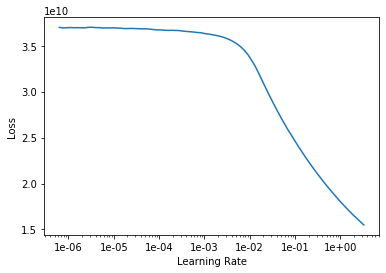

In [20]:
learn.recorder.plot()

In [21]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(14, 7)
    (2): Embedding(9, 5)
    (3): Embedding(164, 28)
    (4): Embedding(10, 6)
    (5): Embedding(71, 17)
    (6): Embedding(804, 68)
    (7): Embedding(3398, 152)
    (8): Embedding(27, 10)
    (9): Embedding(1319, 89)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=387, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=500, out_features=250, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=250, out_features=1, bias=True)
  )
)

In [22]:
# learn.fit_one_cycle(3, 1e-3)

architecture [500, 250]
learning rate 0.0001


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,35335196672.000000,35382956032.000000,188057.562500,00:03
1,34141560832.000000,34056267776.000000,184508.125000,00:03
2,31875319808.000000,31385298944.000000,177127.812500,00:03
3,27069198336.000000,26295408640.000000,162125.812500,00:03
4,18809133056.000000,17869963264.000000,133629.843750,00:03
5,8882118656.000000,8294773248.000000,91042.875000,00:03
6,2373352704.000000,2037759744.000000,45094.675781,00:03
7,393808128.000000,336436256.000000,18004.197266,00:03
8,60146040.000000,106753728.000000,8885.184570,00:03
9,32204430.000000,71973624.000000,6052.692383,00:03


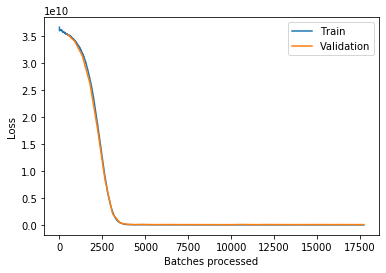

In [29]:
for arch in [[500, 250]]:
    print('architecture', arch)
    for lr in [1e-4]:
        print('learning rate', lr)
        learn = tabular_learner(data, layers=arch, ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=[root_mean_squared_error])
        learn.fit_one_cycle(40, lr)
        learn.recorder.plot_losses()

In [30]:
for i in range(100):
    r = df.iloc[i]
    price = r.planning_price
    prediction = learn.predict(r)[1].data[0].item()
    print(f'{price: <10} {prediction: <30}')

0.0        588.0904541015625             
3058.268591 4070.043701171875             
3058.268591 3222.416748046875             
1502.055443 2108.55859375                 
1502.055443 1621.177001953125             
633.668988 961.3406982421875             
633.668988 1084.553466796875             
1563.272475 2871.658447265625             
1563.272475 2158.388427734375             
1206.559286 1083.66650390625              
1206.559286 1354.1143798828125            
1319.937965 1311.796142578125             
1319.937965 1141.6636962890625            
362.561538 1191.3900146484375            
362.561538 1563.141357421875             
1367.1853210000002 1476.1639404296875            
1367.1853210000002 2076.861328125                
7407.497128 7419.763671875                
7407.497128 7815.8515625                  
13344.538462 14022.1015625                 
13344.538462 14504.9208984375              
7862.4     9346.0068359375               
7862.4     8379.6572265625               
73